# Module

In [2]:
from dotenv import load_dotenv
import os

from typing import Annotated, Literal
from typing_extensions import TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

import json

from langchain_core.messages import ToolMessage

# .env 파일 로드
load_dotenv()

True

### Tavily 정의

In [3]:
tool = TavilySearchResults(max_results=2)
tools = [tool]

### State 정의

In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

### Graph 정의

In [5]:
graph_builder = StateGraph(State)

### LLM 정의
* tavily 툴 바인딩

In [6]:
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools) # tools를 LLM에 바인딩 -> LLM이 자신이 가진 tools를 인식하고 사용할 수 있음

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

### Graph에 노드 및 엣지 추가

In [7]:
graph_builder.add_node("chatbot", chatbot) # chatbot이라는 이름의 노드로, chatbot을 활용

### Tool Node 생성

In [8]:
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
          # tool_call: {'name': 'tavily_search_results_json', 'args': {'query': '오늘 서울 날씨가 어때?'}, 'id': 'call_mDnvuCd8YHmp7XaVK7qYTAAW', 'type': 'tool_call'}
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        # outputs: [ToolMessage(content='[{"url": "https://news.sbs.co.kr/news/endPage.do?news_id=N1007850214", "content": "..."}, {"url": "https://www.yna.co.kr/view/AKR20241024078800009", "content": "..."}]', name='tavily_search_results_json', tool_call_id='call_mDnvuCd8YHmp7XaVK7qYTAAW')]
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool]) # tool_node는 LLM이 호출한 ToolMessage를 받아서, tools에 있는 tool을 실행하고 결과를 반환
graph_builder.add_node("toolss", tool_node) # tools라는 이름의 노드로, tool_node를 활용

### Router 생성

In [9]:
def route_tools(
    state: State,
):
    """
    마지막 메시지에 도구 호출이 있으면 ToolNode로 라우팅하기 위해 conditional_edge에서 사용한다.
    그렇지 않으면 종료로 라우팅한다.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "toolss" # 도구를 사용해야 할 때 "tools"를 반환한다.
    return END


# tools_condition 함수는 챗봇이 도구를 사용해야 하는지 여부를 판단하여,
# 도구를 사용해야 할 때는 "tools"를 반환하고, 직접 응답해도 될 때는 "END"를 반환한다.
# 이 조건부 라우팅은 메인 에이전트 루프를 정의한다.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # 다음 dict는 그래프에 조건의 출력을 특정 노드로 해석하도록 지시할 수 있다.
    # 기본적으로는 identity 함수로 설정되지만, "tools" 이외의 다른 이름을 가진 노드를 사용하려면 dict 값을 변경할 수 있다.
    # 예: "tools": "my_tools"    {"tools": "tools", END: END},
)
# 도구가 호출될 때마다 우리는 다음 단계를 결정하기 위해 다시 챗봇으로 돌아간다.
graph_builder.add_edge("toolss", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

### 시각화

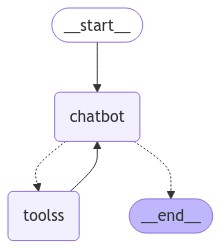

In [10]:
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph().draw_mermaid_png(
                output_file_path="./chatbot_with_tool.png"
            )
        )
    )
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Run

In [39]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
    print("done")

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break


Assistant: 
Assistant: [{"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence. LangGraph allows you to define flows that involve cycles, essential for most agentic architectures, differentiating it from DAG-based solutions."}, {"url": "https://www.langchain.com/langgraph", "content": "Controllable cognitive architecture for any task. LangGraph's flexible API supports diverse control flows - single agent, multi-agent, hierarchical, sequential - and robustly handles realistic, complex scenarios. Ensure reliability with easy-to-add moderation and quality loops that prevent agents from veering off course."}]
Assistant: ## Exploring LangGraph: A New Era of Stateful Applications with LLMs

In the rapidly evolving landscape of artificial intelligence

In [14]:
for event in graph.stream({"messages": [("user", "what is langgraph")]}):
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: [{"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a framework for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with LangChain, LangSmith, and Anthropic tools to build agent and multi-agent workflows."}, {"url": "https://langchain-ai.github.io/langgraph/tutorials/", "content": "LangGraph is a framework for building language agents as graphs. Learn how to use LangGraph to create chatbots, code assistants, planning agents, reflection agents, and more with these notebooks."}]
Assistant: LangGraph is a framework designed for creating stateful, multi-actor applications using large language models (LLMs). It leverages cycles, controllability, and persistence to build agent and multi-agent workflows. LangGraph is used in conjunction with tools like LangChain, LangSmith, and Anthropic to create various types of language agents, such as chatbots, code assistant

In [24]:
for v in event.values():
    print(v["messages"][-1].content)

LangGraph is a framework designed for creating stateful, multi-actor applications using large language models (LLMs). It leverages cycles, controllability, and persistence to build agent and multi-agent workflows. LangGraph is used in conjunction with tools like LangChain, LangSmith, and Anthropic to create various types of language agents, such as chatbots, code assistants, planning agents, and reflection agents. For more information and tutorials, you can visit their [official website](https://langchain-ai.github.io/langgraph/).


In [25]:
event

{'chatbot': {'messages': [AIMessage(content='LangGraph is a framework designed for creating stateful, multi-actor applications using large language models (LLMs). It leverages cycles, controllability, and persistence to build agent and multi-agent workflows. LangGraph is used in conjunction with tools like LangChain, LangSmith, and Anthropic to create various types of language agents, such as chatbots, code assistants, planning agents, and reflection agents. For more information and tutorials, you can visit their [official website](https://langchain-ai.github.io/langgraph/).', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 108, 'prompt_tokens': 246, 'total_tokens': 354, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'stop', 'logprobs': None}, id='run-a0d